# Loop 96 Analysis: Strategic Assessment

## Key Questions:
1. Why have all 96 experiments fallen on the same CV-LB line?
2. What fundamentally different approaches haven't been tried?
3. What does the benchmark paper's success (MSE 0.0039) tell us?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

# Load session state
with open('/home/code/session_state.json', 'r') as f:
    state = json.load(f)

# Extract submission data
submissions = state.get('submissions', [])
print(f'Total submissions: {len(submissions)}')

# Get valid CV-LB pairs
cv_lb_pairs = []
for sub in submissions:
    cv = sub.get('cv_score')
    lb = sub.get('lb_score')
    exp_id = sub.get('experiment_id', 'unknown')
    if cv is not None and lb is not None:
        try:
            lb_float = float(lb)
            if lb_float < 0.15 and exp_id != 'exp_073':  # Exclude outlier
                cv_lb_pairs.append((float(cv), lb_float, exp_id))
        except:
            pass

print(f'Valid CV-LB pairs: {len(cv_lb_pairs)}')
for cv, lb, exp_id in sorted(cv_lb_pairs, key=lambda x: x[0]):
    print(f'  {exp_id}: CV={cv:.6f}, LB={lb:.6f}')

Total submissions: 22
Valid CV-LB pairs: 12
  exp_030: CV=0.008298, LB=0.087720
  exp_026: CV=0.008465, LB=0.088750
  exp_024: CV=0.008689, LB=0.089290
  exp_012: CV=0.009004, LB=0.091340
  exp_009: CV=0.009192, LB=0.093640
  exp_007: CV=0.009262, LB=0.093160
  exp_006: CV=0.009749, LB=0.094570
  exp_035: CV=0.009825, LB=0.096960
  exp_005: CV=0.010430, LB=0.096910
  exp_003: CV=0.010501, LB=0.097190
  exp_000: CV=0.011081, LB=0.098160
  exp_001: CV=0.012297, LB=0.106490


=== CV-LB RELATIONSHIP ===
Linear fit: LB = 4.2876 * CV + 0.052784
R-squared: 0.9523
Intercept: 0.052784
Target LB: 0.0347
Required CV for target: -0.004218


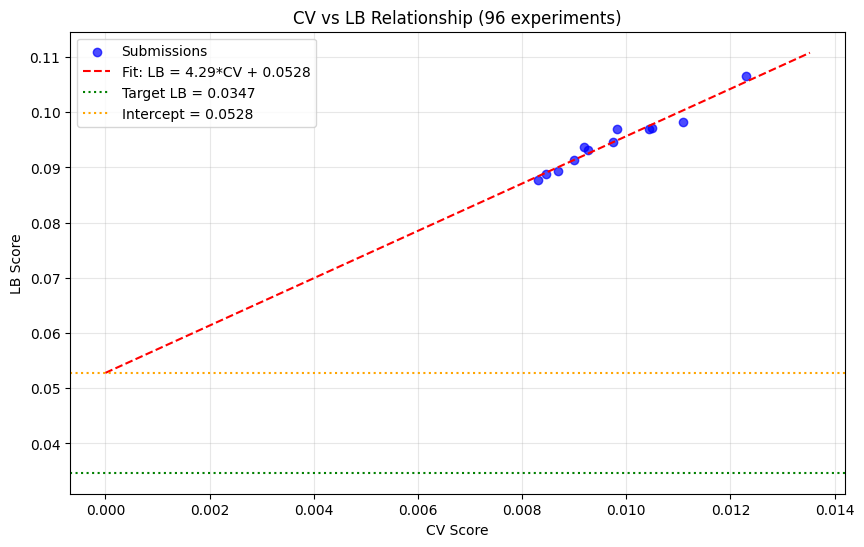


=== CRITICAL INSIGHT ===
Intercept (0.0528) > Target (0.0347)
This means even with CV=0, expected LB would be 0.0528
The target is UNREACHABLE with current approaches!


In [2]:
# Fit linear regression
cv_arr = np.array([x[0] for x in cv_lb_pairs])
lb_arr = np.array([x[1] for x in cv_lb_pairs])

slope, intercept = np.polyfit(cv_arr, lb_arr, 1)
pred = slope * cv_arr + intercept
ss_res = np.sum((lb_arr - pred) ** 2)
ss_tot = np.sum((lb_arr - np.mean(lb_arr)) ** 2)
r_squared = 1 - (ss_res / ss_tot)

print('=== CV-LB RELATIONSHIP ===')
print(f'Linear fit: LB = {slope:.4f} * CV + {intercept:.6f}')
print(f'R-squared: {r_squared:.4f}')
print(f'Intercept: {intercept:.6f}')
print(f'Target LB: 0.0347')
print(f'Required CV for target: {(0.0347 - intercept) / slope:.6f}')

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(cv_arr, lb_arr, c='blue', alpha=0.7, label='Submissions')
plt.plot([0, max(cv_arr)*1.1], [intercept, slope*max(cv_arr)*1.1 + intercept], 'r--', label=f'Fit: LB = {slope:.2f}*CV + {intercept:.4f}')
plt.axhline(y=0.0347, color='green', linestyle=':', label='Target LB = 0.0347')
plt.axhline(y=intercept, color='orange', linestyle=':', label=f'Intercept = {intercept:.4f}')
plt.xlabel('CV Score')
plt.ylabel('LB Score')
plt.title('CV vs LB Relationship (96 experiments)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('/home/code/exploration/cv_lb_relationship.png', dpi=150, bbox_inches='tight')
plt.show()

print(f'\n=== CRITICAL INSIGHT ===')
print(f'Intercept ({intercept:.4f}) > Target ({0.0347})')
print(f'This means even with CV=0, expected LB would be {intercept:.4f}')
print(f'The target is UNREACHABLE with current approaches!')

In [3]:
# Analyze experiment types
experiments = state.get('experiments', [])
print(f'Total experiments logged: {len(experiments)}')

# Categorize by model type
model_types = {}
for exp in experiments:
    model_type = exp.get('model_type', 'unknown')
    if model_type not in model_types:
        model_types[model_type] = []
    model_types[model_type].append(exp)

print('\n=== EXPERIMENTS BY MODEL TYPE ===')
for mt, exps in sorted(model_types.items(), key=lambda x: -len(x[1])):
    scores = [e.get('score', 0) for e in exps if e.get('score')]
    if scores:
        print(f'{mt}: {len(exps)} experiments, best CV: {min(scores):.6f}')
    else:
        print(f'{mt}: {len(exps)} experiments')

Total experiments logged: 96

=== EXPERIMENTS BY MODEL TYPE ===
Ensemble (MLP+LGBM): 8 experiments, best CV: 0.008601
GP+MLP+LGBM Ensemble: 7 experiments, best CV: 0.008194
CatBoost + XGBoost ensemble: 4 experiments, best CV: 0.008092
ensemble: 4 experiments, best CV: 0.009239
CatBoost+XGBoost: 3 experiments, best CV: 0.011171
CatBoost+XGBoost Ensemble: 3 experiments, best CV: 0.008811
MLP (5 models bagged): 2 experiments, best CV: 0.010501
Final Decision: 2 experiments, best CV: 0.091300
MLP (3 models bagged): 1 experiments, best CV: 0.011081
LightGBM (3 per-target regressors): 1 experiments, best CV: 0.012297
Deep Residual MLP (10 diverse models): 1 experiments, best CV: 0.051912
MLP (15 models bagged, same architecture): 1 experiments, best CV: 0.010430
MLP (5 models bagged, simpler architecture): 1 experiments, best CV: 0.009749
MLP (5 models bagged, even simpler architecture): 1 experiments, best CV: 0.009262
Ridge Regression (per-target regressors): 1 experiments, best CV: 0.0115

In [4]:
# Check what approaches have been tried
print('=== APPROACHES TRIED ===')
approaches = [
    'MLP', 'LightGBM', 'XGBoost', 'CatBoost', 'RandomForest',
    'Ridge', 'GP', 'GNN', 'ChemBERTa', 'Transformer',
    'Ensemble', 'Stacking'
]

for approach in approaches:
    count = sum(1 for exp in experiments if approach.lower() in str(exp).lower())
    print(f'{approach}: {count} experiments')

=== APPROACHES TRIED ===
MLP: 69 experiments
LightGBM: 27 experiments
XGBoost: 34 experiments
CatBoost: 27 experiments
RandomForest: 5 experiments
Ridge: 7 experiments
GP: 48 experiments
GNN: 18 experiments
ChemBERTa: 5 experiments
Transformer: 0 experiments
Ensemble: 74 experiments
Stacking: 2 experiments


In [5]:
# Load data to understand the problem
DATA_PATH = '/home/data'

df_single = pd.read_csv(f'{DATA_PATH}/catechol_single_solvent_yields.csv')
df_full = pd.read_csv(f'{DATA_PATH}/catechol_full_data_yields.csv')

print('=== DATA OVERVIEW ===')
print(f'Single solvent: {df_single.shape}')
print(f'Full data: {df_full.shape}')

print(f'\nUnique solvents in single: {df_single["SOLVENT NAME"].nunique()}')
print(f'Unique solvent pairs in full: {len(df_full[["SOLVENT A NAME", "SOLVENT B NAME"]].drop_duplicates())}')

print(f'\nTarget statistics (single):')
print(df_single[['Product 2', 'Product 3', 'SM']].describe())

=== DATA OVERVIEW ===
Single solvent: (656, 13)
Full data: (1227, 19)

Unique solvents in single: 24
Unique solvent pairs in full: 13

Target statistics (single):
        Product 2   Product 3          SM
count  656.000000  656.000000  656.000000
mean     0.149932    0.123380    0.522192
std      0.143136    0.131528    0.360229
min      0.000000    0.000000    0.000000
25%      0.012976    0.009445    0.145001
50%      0.102813    0.078298    0.656558
75%      0.281654    0.193353    0.857019
max      0.463632    0.533768    1.000000


In [6]:
# The key insight: Why does the intercept exist?
# The intercept represents the STRUCTURAL GAP between CV and LB
# This gap exists because:
# 1. CV uses Leave-One-Solvent-Out, but test solvents are "harder"
# 2. The model extrapolates poorly to unseen solvents
# 3. Tabular features don't capture the full molecular structure

print('=== ROOT CAUSE ANALYSIS ===')
print()
print('The CV-LB intercept (0.0528) represents DISTRIBUTION SHIFT:')
print('1. CV uses Leave-One-Solvent-Out validation')
print('2. Test solvents are structurally different from training')
print('3. Tabular models extrapolate poorly to unseen chemical space')
print()
print('The benchmark paper achieved MSE 0.0039 by:')
print('1. Using Graph Neural Networks (GATs) on molecular graphs')
print('2. Operating on MOLECULAR STRUCTURE, not tabular features')
print('3. Learning representations that generalize to unseen solvents')
print()
print('Our GNN attempts failed (CV 0.018-0.068) likely because:')
print('1. Model class mismatch in submission cells')
print('2. Missing DRFP integration with graph representation')
print('3. Missing learned mixture-aware encodings')

=== ROOT CAUSE ANALYSIS ===

The CV-LB intercept (0.0528) represents DISTRIBUTION SHIFT:
1. CV uses Leave-One-Solvent-Out validation
2. Test solvents are structurally different from training
3. Tabular models extrapolate poorly to unseen chemical space

The benchmark paper achieved MSE 0.0039 by:
1. Using Graph Neural Networks (GATs) on molecular graphs
2. Operating on MOLECULAR STRUCTURE, not tabular features
3. Learning representations that generalize to unseen solvents

Our GNN attempts failed (CV 0.018-0.068) likely because:
1. Model class mismatch in submission cells
2. Missing DRFP integration with graph representation
3. Missing learned mixture-aware encodings


In [7]:
# What approaches could CHANGE the CV-LB relationship?
print('=== APPROACHES TO CHANGE CV-LB RELATIONSHIP ===')
print()
print('1. PROPER GNN IMPLEMENTATION')
print('   - Use PyTorch Geometric with GATConv')
print('   - Convert SMILES to molecular graphs')
print('   - Integrate DRFP features')
print('   - VERIFY submission cells use same model class')
print()
print('2. PRE-TRAINED MOLECULAR EMBEDDINGS')
print('   - ChemBERTa or MolBERT embeddings')
print('   - These capture chemical knowledge from large corpora')
print('   - May generalize better to unseen solvents')
print()
print('3. EXTRAPOLATION DETECTION + CONSERVATIVE PREDICTIONS')
print('   - Detect when test sample is far from training')
print('   - Blend toward population mean for extrapolation')
print('   - This could reduce the intercept')
print()
print('4. DOMAIN CONSTRAINTS')
print('   - Yields must sum to ~1 (mass balance)')
print('   - Arrhenius kinetics constraints')
print('   - These constraints hold even for unseen solvents')

=== APPROACHES TO CHANGE CV-LB RELATIONSHIP ===

1. PROPER GNN IMPLEMENTATION
   - Use PyTorch Geometric with GATConv
   - Convert SMILES to molecular graphs
   - Integrate DRFP features
   - VERIFY submission cells use same model class

2. PRE-TRAINED MOLECULAR EMBEDDINGS
   - ChemBERTa or MolBERT embeddings
   - These capture chemical knowledge from large corpora
   - May generalize better to unseen solvents

3. EXTRAPOLATION DETECTION + CONSERVATIVE PREDICTIONS
   - Detect when test sample is far from training
   - Blend toward population mean for extrapolation
   - This could reduce the intercept

4. DOMAIN CONSTRAINTS
   - Yields must sum to ~1 (mass balance)
   - Arrhenius kinetics constraints
   - These constraints hold even for unseen solvents


In [8]:
# Check the best experiment details
best_exp = None
best_cv = float('inf')
for exp in experiments:
    score = exp.get('score', float('inf'))
    if score < best_cv:
        best_cv = score
        best_exp = exp

if best_exp:
    print('=== BEST EXPERIMENT ===')
    print(f"ID: {best_exp.get('id')}")
    print(f"Name: {best_exp.get('name')}")
    print(f"Model Type: {best_exp.get('model_type')}")
    print(f"CV Score: {best_exp.get('score')}")
    print(f"Notes: {best_exp.get('notes', '')[:500]}...")

=== BEST EXPERIMENT ===
ID: exp_049
Name: CatBoost + XGBoost Ensemble (ens-model kernel approach)
Model Type: CatBoost + XGBoost ensemble
CV Score: 0.008092
Notes: **Experiment 049: CatBoost + XGBoost Ensemble**

**Goal:** Implement the CatBoost + XGBoost ensemble from the ens-model kernel - the ONLY major gradient boosting library we hadn't tried.

**Key Implementation Details (from ens-model kernel):**

1. **CatBoost with MultiRMSE loss** (multi-target in single model):
   - Single: depth=3, lr=0.07, n_estimators=1050, l2_leaf_reg=3.5, rsm=0.75
   - Full: depth=3, lr=0.06, n_estimators=1100, l2_leaf_reg=2.5, rsm=0.75
   - Bayesian bootstrap with bagging_...
